# Lending Club -- Which loans will be paid back?

[Lending Club](https://www.lendingclub.com) is a company that operates in the USA and facilitates peer to peer loans. The lenders can invest their money to fund the loans and in return they earn profit from the interests paid by the borrowers. The investers can choose to invest in one of the five categories; **A, B, C, D,** and **E**. The investment strategy **A** yields the minimum returns but also involves a minimum risk while the investment strategy **E** yields maximum returns but involves the highest risk that loan will not be paid back.

The Lending Club have provided its [data](https://www.lendingclub.com/info/download-data.action) for researches to use for study purpose.

## Data

The data used in this study is composed of four files available on the website of the Lending Club; _LoanStats3a.csv, LoanStats3b.csv, LoanStats3c.csv_ and _LoanStats3d.csv_ which contain data for the loans facilitated by the company in 2007-2011, 2012-2013, 2014, and 2015 respectively.

## Python libraries used for the study
The following python libraries are being used in theis study:
1. `pandas`
1. `sklearn`
1. `matplotlib`
1. `numpy`
1. `seaborn`

## Load Data
After downloading the datasets, the extra rows on the top and bottom of the csv files are removed that would make it hard for pandas to read the files cleanly.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

loans_a = pd.read_csv("raw_data/LoanStats3a.csv", low_memory = False)
loans_b = pd.read_csv("raw_data/LoanStats3b.csv", low_memory = False)
loans_c = pd.read_csv("raw_data/LoanStats3c.csv", low_memory = False)
loans_d = pd.read_csv("raw_data/LoanStats3d.csv", low_memory = False)
    
loans = loans_a.append(loans_b, ignore_index = True)
loans = loans.append(loans_c, ignore_index = True)
loans = loans.append(loans_d, ignore_index = True)
    
del loans_a
del loans_b
del loans_c
del loans_d

## Data cleaning

### Remove sparse variables

There are 141 variables in this data set. Many of these variables are very sparse and hence not very useful. The columns that have 10% or more missing data are removed.

In [2]:
loans = loans[loans.columns[loans.isnull().mean() < 0.1]]

### Drop long descriptive variables

There are 84 variables after dropping the sparse variables. We would also like to drop the highly descriptive variables $pymnt\_plan$ and $emp\_title$ for this study. Although these may be useful for natural language processing or words analysis.

In [3]:
cols_to_drop = ['pymnt_plan', 'emp_title']
loans.drop(cols_to_drop, axis=1, inplace=True)

### Format the date columns

The dates need to be formatted as pandas datetime objects. Lets do that

In [4]:
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for col in date_cols:
    loans[col] = pd.to_datetime(loans[col], format = "%b-%Y")

### Format the rate columns

The rate columns need to be formatted as python float variables

In [5]:
rate_cols = ['int_rate', 'revol_util']
for col in rate_cols:
    loans[col] = pd.to_numeric(loans[col].str.replace('%',''))

### Clean the target variable -- $loan\_status$
There are multiple values of the variable $loan\_status$


|Variable|Frequency|Percentage|
|--------|---------|------|
|Fully Paid|637715|71.9%|
|Charged Off|147424|16.6%|
|Current|92970|10.5%|
|Late (31-120 days)|3545|0.4%|
|Does not meet the credit policy. Status:Fully Paid|1988|0.2%|
|In Grace Period|1896|0.2%|
|Late (16-30 days)|965|0.1%|
|Does not meet the credit policy. Status:Charged Off|761|0.1%|
|Default|176|0.0%|

We would like to remove the $loan\_status = Current$ records as these loans are still not fully paid back and we dont know their final outcome. For our purpose we will only consider the records where $loan\_status$ has the following values
1. **`Fully Paid`** and count it as **`0`**
1. **`Charged Off`** and count it as **`1`**
1. **`Does not meet the credit policy. Status:Fully Paid`** and count it as **`0`**
1. **`Does not meet the credit policy. Status:Charged Off`** and count it as **`1`**

We will remove the records with the following outcomes in addition to **`Current`**
1. **`Late (31-120 days)`**
1. **`In Grace Period`**
1. **`Late (10-30 days)`** and
1. **`Default`**

In [6]:
loans['loan_status'] = loans['loan_status'].map({'Fully Paid': 0
         , 'Does not meet the credit policy. Status:Fully Paid': 0
         , 'Charged Off' : 1
         , 'Does not meet the credit policy. Status:Charged Off' : 1})
    
loans = loans[(loans['loan_status'] == 0) | (loans['loan_status'] == 1)]

### Further missing values
It is important to investigate the variables containing less than 20% missing values

In [7]:
allMissing = loans.isnull().sum().sort_values(ascending=False)
percentage = (loans.isnull().sum()/loans.isnull().count()).sort_values(ascending=False)
missingData = pd.concat([allMissing, percentage*100], axis=1, keys=['TotalMissing', 'Percentage'])
missingData.head(50)

,TotalMissing,Percentage
pct_tl_nvr_dlq,70425,8.938453
avg_cur_bal,70288,8.921065
mo_sin_old_rev_tl_op,70277,8.919669
mo_sin_rcnt_rev_tl_op,70277,8.919669
num_rev_accts,70277,8.919669
num_rev_tl_bal_gt_0,70276,8.919542
total_rev_hi_lim,70276,8.919542
tot_cur_bal,70276,8.919542
tot_coll_amt,70276,8.919542
mo_sin_rcnt_tl,70276,8.919542


The variables that have 6.34% or more missing values can be dropped as these are still significant.

In [8]:
drop_missing = ['pct_tl_nvr_dlq', 'avg_cur_bal', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts'
                , 'num_rev_tl_bal_gt_0', 'total_rev_hi_lim', 'tot_cur_bal', 'tot_coll_amt', 'mo_sin_rcnt_tl'
                , 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl'
                , 'num_op_rev_tl', 'tot_hi_cred_lim', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m'
                , 'total_il_high_credit_limit', 'num_sats', 'num_bc_sats', 'bc_util', 'percent_bc_gt_75'
                , 'bc_open_to_buy', 'mths_since_recent_bc', 'acc_open_past_24mths', 'total_bal_ex_mort'
                , 'total_bc_limit', 'mort_acc']
loans.drop(labels = drop_missing, axis = 1, inplace = True)

The variable $pub\_rec\_bankruptcies$ is a number of public record bankruptcies as explained in the data dictionary on the data page of lending club. This variable has a zero value for most of the cases while some loans have this value more than zero. The maximum of this value found in this data set is 12. I am tempted to drop this variable. The reason I am dropping this is that I do not want to remove 1365 observations and also do not want to replace the missing values with my assumptions.

The variable $last\_pymnt\_d$ is missing whenever the debt is bad. I am again dropping this variable.

The variables $revol\_util$, $collections\_12\_mths\_ex\_med$, $chargeoff\_within\_12\_mths$, $tax\_liens$, $title$, $last\_credit\_pull\_d$ should also be dropped. Also the variables $delinq\_amnt$, $acc\_now\_delinq$, $delinq\_2yrs$, $earliest\_cr\_line$, $inq\_last\_6mths$, $open\_acc$, $pub\_rec$, and $total\_acc$ are missing whenever the value of $verification\_status$ is 'Not Verified'. We are going to drop these variables too.

Finally the observationas where the variables $annual\_inc$ and $dti$ are missing can be dropped.

In [9]:
drop_missing2 = ['pub_rec_bankruptcies', 'last_pymnt_d', 'revol_util', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths'
                 , 'tax_liens', 'title', 'last_credit_pull_d', 'delinq_amnt', 'acc_now_delinq', 'delinq_2yrs'
                 , 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc']
loans.drop(labels = drop_missing2, axis = 1, inplace = True)
loans = loans[loans['annual_inc'].notnull()]
loans = loans[loans['dti'].notnull()]

### Add numeric grading

The categorical grades and subgrades can be replaced with the numeric scale assuming that the grades `A1, A2, A3, A4, A5, B1, ..., G5` are on a linear scale from 1 to 35.

In [10]:
loans['num_grade'] = loans['sub_grade'].map({'A1': 1, 'A2': 2, 'A3' : 3, 'A4' : 4, 'A5' : 5
                                            , 'B1' : 6, 'B2' : 7, 'B3' : 8, 'B4': 9, 'B5' : 10
                                            , 'C1' : 11, 'C2' : 12, 'C3' : 13, 'C4': 14, 'C5' : 15
                                            , 'D1' : 16, 'D2' : 17, 'D3' : 18, 'D4': 19, 'D5' : 20
                                            , 'E1' : 21, 'E2' : 22, 'E3' : 23, 'E4': 24, 'E5' : 25
                                            , 'F1' : 26, 'F2' : 27, 'F3' : 28, 'F4': 29, 'F5' : 30
                                            , 'G1' : 31, 'G2' : 32, 'G3' : 33, 'G4': 34, 'G5' : 35})
loans.drop(labels = ['grade', 'sub_grade'], axis = 1, inplace = True)

## Distributions and impact on the $loan\_status$

C:\Users\amjad\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\amjad\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


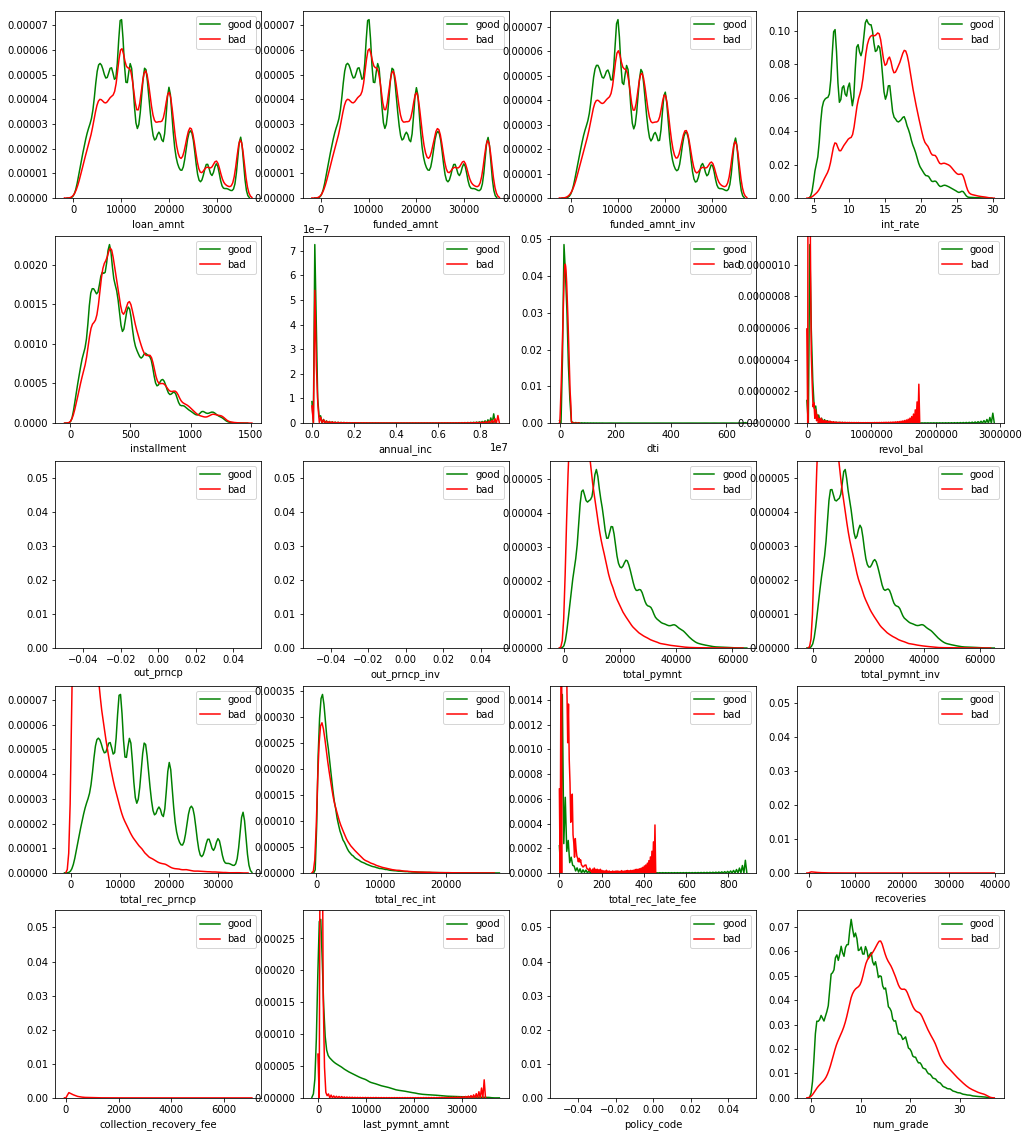

In [11]:
num_cols = loans.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('loan_status')
loans_good = loans[loans['loan_status'] == 0]
loans_bad = loans[loans['loan_status'] == 1]
f, axes = plt.subplots(figsize=(17,20), ncols=4, nrows=5)

for i, col in enumerate(num_cols):
    sns.kdeplot(loans_good[col], color = 'g', label = 'good', ax = axes[divmod(i, 4)[0]][i % 4])
    sns.kdeplot(loans_bad[col], color = 'r', label = 'bad', ax = axes[divmod(i, 4)[0]][i % 4])
    axes[divmod(i, 4)[0]][i % 4].set_xlabel(col)
    axes[divmod(i, 4)[0]][i % 4].legend()

plt.show()

The variable $dti$ should be capped at 100% as debt-to-income ratio in a month cannot be more than 100%. Also consider the fact that all six of the loans that have more than 100% $dti$ are fully paid or `good`. Also, we notice that for some reason we have six observations where the variable $out\_prncp$ is 100. This cannot be true; a more detailed investiigation shows that these observations are erroneous and can be dropped.

A further investigation shows that the variables $out\_prncp$, $out\_prncp\_inv$, and $policy\_code$ have zero standard deviation and can simply be dropped.

C:\Users\amjad\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\amjad\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


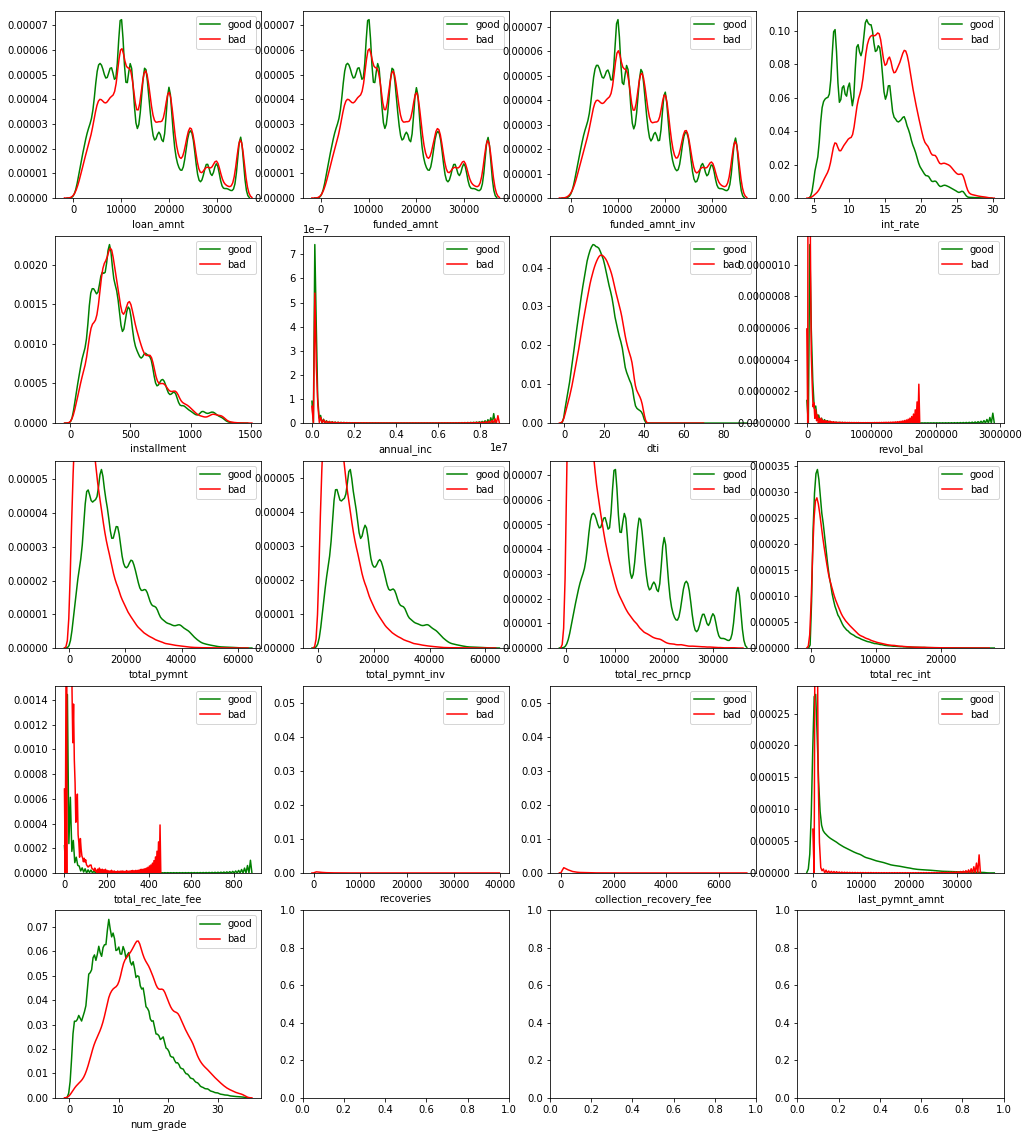

In [12]:
loans[loans['dti'] > 100] = 100
loans = loans[loans['out_prncp'] < 100]
loans.drop(labels = ['out_prncp', 'out_prncp_inv', 'policy_code'], axis = 1, inplace = True)
num_cols.remove('out_prncp')
num_cols.remove('out_prncp_inv')
num_cols.remove('policy_code')

loans_good = loans[loans['loan_status'] == 0]
loans_bad = loans[loans['loan_status'] == 1]
f, axes = plt.subplots(figsize=(17,20), ncols=4, nrows=5)

for i, col in enumerate(num_cols):
    sns.kdeplot(loans_good[col], color = 'g', label = 'good', ax = axes[divmod(i, 4)[0]][i % 4])
    sns.kdeplot(loans_bad[col], color = 'r', label = 'bad', ax = axes[divmod(i, 4)[0]][i % 4])
    axes[divmod(i, 4)[0]][i % 4].set_xlabel(col)
    axes[divmod(i, 4)[0]][i % 4].legend()

plt.show()

## Barplots by $loan\_status$
At the moment it seems that the date variable $issue\_d$ may not be very useful in explaining the response variable $loan\_status$.

The variable $zip\_code$ has too many unique values and at this stage we would like to ignore that to reduce the number of modelling features. Also the variables $disbursement\_method$ and $hardship\_flag$ have zero deviations in their values. We will drop these two variables too from the modelling features.

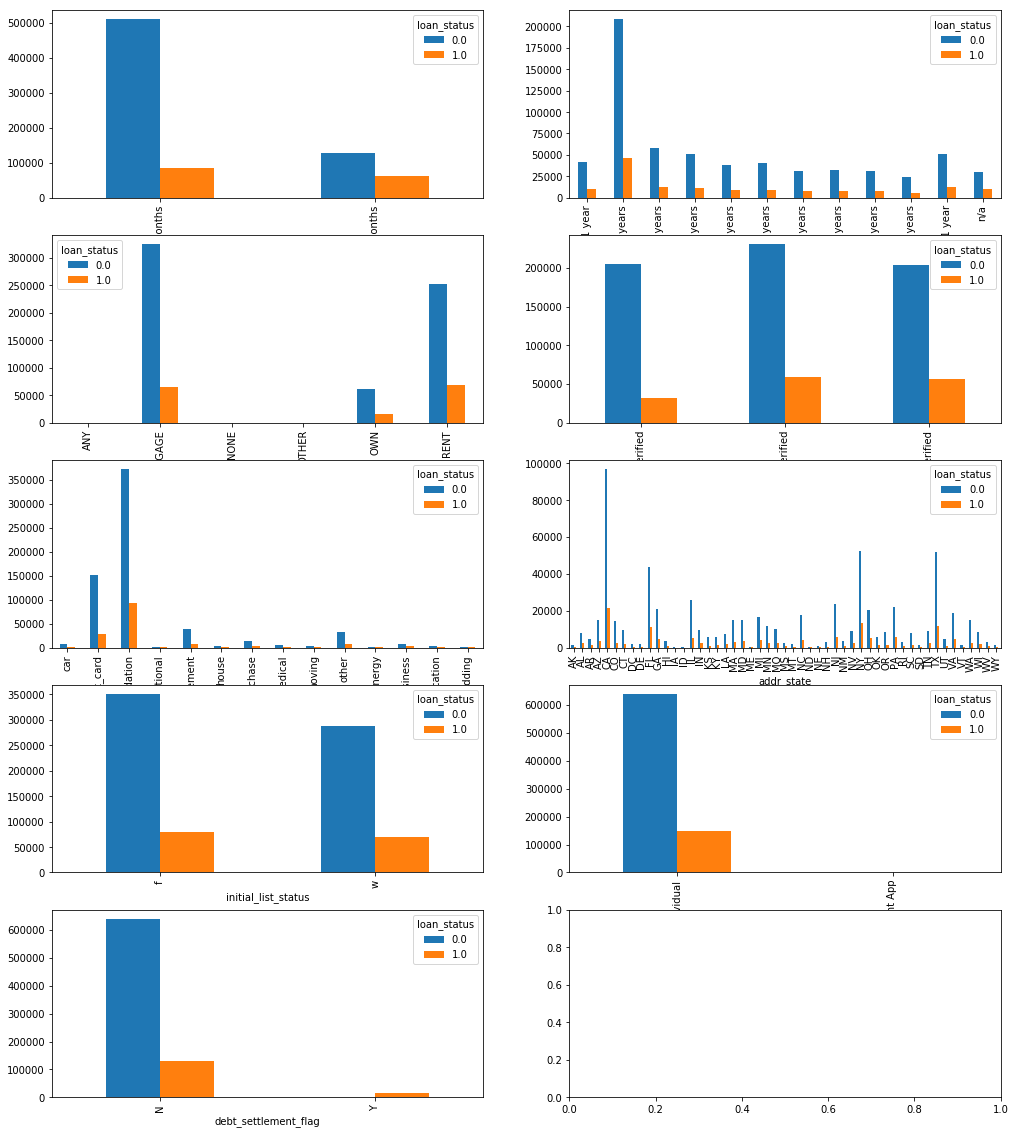

In [13]:
loans.drop(labels = ['issue_d', 'zip_code', 'disbursement_method', 'hardship_flag'], axis = 1, inplace = True)

f, axes = plt.subplots(figsize=(17,20), ncols=2, nrows=5)
for i, col in enumerate(loans.select_dtypes(exclude=[np.number]).columns.tolist()):
    loans.groupby([col,'loan_status']).size().unstack(fill_value=0).plot(ax=axes[divmod(i, 2)[0]][i % 2],kind='bar')
plt.show()

## Feature Selection
Let us fit a simple Logistic Regression model with the default parameters using all the explanatory variables we decided to keep so far. We will apply 5 Folds cross validation to get a better understanding of how the model performs on average on all five of the test sets of the cross validation.

We have decided to choose **F1 Score** as the performance metric in this case. F1 score is a harmonic mean of the **precision** and **recall** metrics. These are defined as:
### Precision
Precision is the number of True Positives divided by the number of True Positives and False Positives of confusion matrix. In simple words, it is the number of positive predictions divided by the total number of positive class values predicted.
$$precision = \frac{TP}{TP + FP}$$
### Recall
Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. In other words, it is the number of positive predictions divided by the number of positive class values in the test data.
$$recall = \frac{TP}{TP + FN}$$
### F1 Score
$$\frac{1}{F1\_score} = \frac{1}{2}\left(\frac{1}{precision} + \frac{1}{recall}\right)$$
or
$$F1\_score = \frac{2 \times precision \times recall}{precision + recall}$$

Since, our problem does not have balanced outcomes, the _accuracy_ is not a very good performance metric, e.g., if there are 5% bad loans, a model that predicts all good loans will still have a 95% accuracy but we know that this will be a very bad model.

We have taken $loan\_status = bad$ as the positive outcome in this case.

From the distribution plots, it seems like the variable $annual\_inc$ is not very helpful in explaining the response variable. Moreover, the variables:
1. $revol\_bal$ and $total\_rec\_late\_fee$
1. $total\_pymnt$ and $total\_pymnt\_inv$
1. $recoveries$ and $collection\_recovery\_fee$
1. $funded\_amnt$, $loan\_amnt$ and $funded\_amnt\_inv$
are strongly correlated. We will drop the variables $annual\_inc$, $revol\_bal$, $total\_pymnt\_inv$, $collection\_recovery\_fee$, $loan\_amnt$, and $funded\_amnt\_inv$. The average performance score will then be compared to see if the results worsen.

In [14]:
logr = LogisticRegression()
X_all = pd.get_dummies(loans.loc[:, loans.columns != 'loan_status'], drop_first = True)
y = loans['loan_status']
all_cols_score = np.mean(cross_val_score(logr, X_all, y, cv=5, scoring='f1'))

logr = LogisticRegression()
X_subset = pd.get_dummies(loans[loans.columns.difference(['loan_status', 'annual_inc', 'revol_bal', 'total_pymnt_inv'
                                                         , 'collection_recovery_fee', 'loan_amnt', 'funded_amnt_inv'
                                                         , 'annual_inc'])], drop_first = True)
sub_cols_score = np.mean(cross_val_score(logr, X_subset, y, cv=5, scoring='f1'))
print('F1 Score with all explanatory variables:   ' +
      '{all_c:.6f}\nF1 Score with subset of explanatory variables:   {sub_c:.6f}'.format(
all_c = all_cols_score, sub_c = sub_cols_score))

F1 Score with all explanatory variables:   0.998197
F1 Score with subset of explanatory variables:   0.999429


It seems that the variables excluded have indeed improved the average score by a very small margin. We will, therefore, remove these variables form the modelling features.

In [15]:
loans.drop(labels = ['annual_inc', 'revol_bal', 'total_pymnt_inv', 'collection_recovery_fee'
                     , 'loan_amnt', 'funded_amnt_inv', 'annual_inc'], axis = 1, inplace = True)